In [10]:
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
df = pd.read_csv('combined_new.csv')
df = df.drop(df.columns[:22], axis=1) #meta-data
df = df.drop('name', axis=1)

In [12]:
df

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,mutation
0,0.764607,0.413889,12.984508,31.371966,32.962023,33.434414,32.808978,33.970126,5655.480418,23.987224,...,0.006336,6.705198,0.413742,9.164744,0.553242,0.002479,2080.874813,0.136338,1.836137,1
1,0.700338,0.574578,20.201616,35.159024,38.814302,30.105778,39.348493,40.599309,11620.060974,24.623216,...,0.002289,7.885558,0.335306,23.846467,1.139757,0.000671,11060.413114,0.399200,1.403567,1
2,0.833499,0.628468,30.691706,48.835737,66.935507,49.859821,74.262942,74.262942,40062.095982,40.704539,...,0.000414,7.686420,0.336114,250.738294,0.595404,0.000234,15771.669270,0.158388,1.010810,1
3,0.897789,0.814888,39.344971,48.282703,60.120200,52.912316,52.524104,60.599487,57753.651952,43.347697,...,0.002813,7.675965,0.073041,109243.831794,8.224631,0.000094,1407.941379,0.031227,0.132257,1
4,0.460290,0.404966,5.120320,12.643813,13.173549,12.001463,9.470362,14.065837,277.532826,5.819821,...,0.031387,4.432620,0.055285,3036.609862,1.274256,0.013081,27.143444,0.010071,1.273143,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.838671,0.737646,34.465588,46.723754,52.780068,48.619010,52.546540,59.389355,43174.670397,39.185879,...,0.007598,6.397916,0.056563,30146.416297,2.718173,0.000555,333.254499,0.028774,0.211518,-1
156,0.701843,0.624692,77.257905,123.673536,107.975285,141.316130,140.709601,157.410932,516275.449156,86.799431,...,0.000156,7.892259,0.651680,2.209869,0.516443,0.000127,101139.763365,0.468515,1.021151,-1
157,0.717008,0.699893,54.035452,77.205354,80.000120,82.769508,88.281699,91.358215,140840.571769,55.356864,...,0.001953,7.520979,0.138596,9502.099817,6.904314,0.000076,2725.914761,0.053718,0.097691,-1
158,0.903791,0.823936,48.942985,59.401462,69.050713,68.369865,67.059799,70.218750,110941.853739,53.686478,...,0.001026,7.002111,0.219702,5968.699692,1.857575,0.000205,3435.583923,0.194350,0.316872,-1


In [13]:
df_no_label = df.drop('mutation', axis=1)

In [27]:
df_known = df.loc[df['mutation'].isin([1, 0])]
df_unknown = df.loc[df['mutation'].isin([-1])]
df_known_no_label = df_known.drop(df.columns[-1:], axis=1)
df_unknown_no_label = df_unknown.drop(df.columns[-1:], axis=1)

# K-means++

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


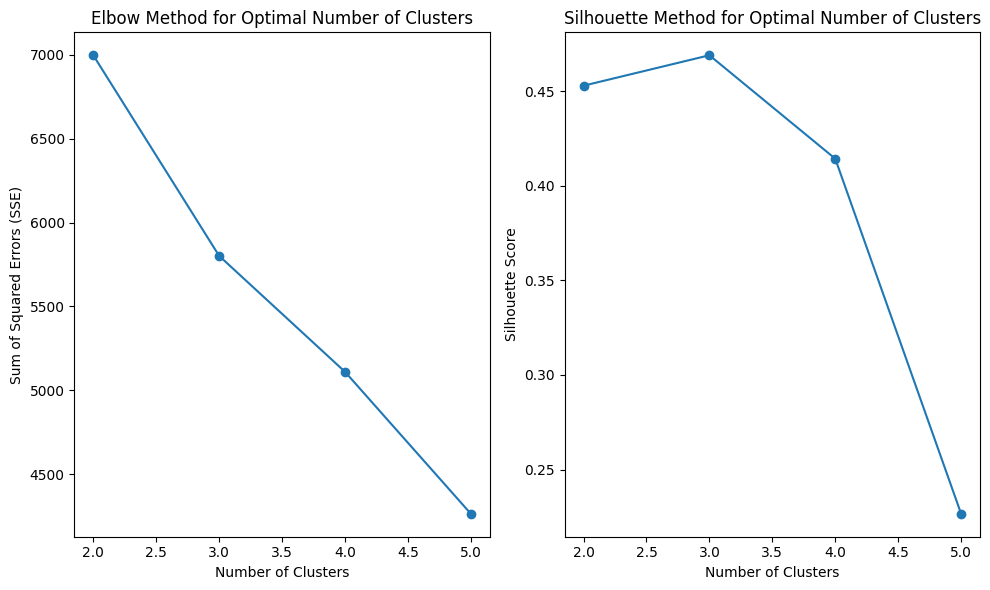

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


# Стандартизируем данные
scaled_df = StandardScaler().fit_transform(df_known_no_label)

# Используем метод локтя для определения оптимального числа кластеров
sse = []
silhouette_scores = []
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=1)
    kmeans.fit(scaled_df)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_df, kmeans.labels_, metric='euclidean'))

# Создаем график
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 6), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal Number of Clusters')

plt.subplot(1, 2, 2)
plt.plot(range(2, 6), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal Number of Clusters')

plt.tight_layout()
plt.show()

## Predict for unknown

In [20]:
scale = StandardScaler().fit(df_known_no_label)
scaled_df = scale.transform(df_known_no_label)

kmeans = KMeans(n_clusters=2, init='k-means++', random_state=1)
y_pred = kmeans.fit_predict(scaled_df)
count_cluster_0 = np.sum(y_pred == 0)
count_cluster_1 = np.sum(y_pred == 1)
df_known['predict'] = y_pred

print("На известных данных")
count_first = df_known[(df_known['mutation'] == 1) & (df_known['predict'] == 0)].shape[0]
count_second = df_known[(df_known['mutation'] == 1) & (df_known['predict'] == 1)].shape[0]
print(f"Количество точек в первом / втором кластере: {count_cluster_0} (мутаций из них {count_first}) / {count_cluster_1} (мутаций из них {count_second})")
print(f"Количество в оригинальном датасете мутации / без мутации: {(df['mutation'] == 1).sum()} / {(df['mutation'] == 0).sum()}")

print("\nНа неизвестных данных")
scaled_df = scale.transform(df_unknown_no_label)
y_pred = kmeans.predict(scaled_df)
count_cluster_0 = np.sum(y_pred == 0)
count_cluster_1 = np.sum(y_pred == 1)
print(f"Количество точек в первом / втором кластере: {count_cluster_0} / {count_cluster_1}")

На известных данных
Количество точек в первом / втором кластере: 80 (мутаций из них 59) / 19 (мутаций из них 15)
Количество в оригинальном датасете мутации / без мутации: 74 / 25

На неизвестных данных
Количество точек в первом / втором кластере: 47 / 14


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-20-1e30fbef60b4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_known['predict'] = y_pred


# AgglomerativeClustering

In [21]:
df_known_no_label = df_known.drop(df.columns[-1:], axis=1)
df_unknown_no_label = df_unknown.drop(df.columns[-1:], axis=1)
df_known = df.loc[df['mutation'].isin([1, 0])]

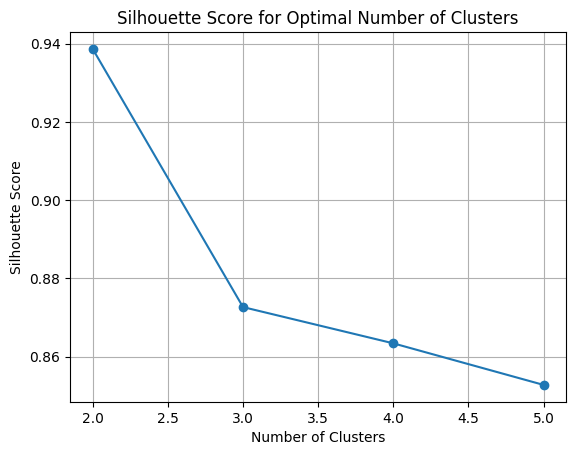

In [22]:
from sklearn.cluster import AgglomerativeClustering


# Используем метод локтя для определения оптимального числа кластеров
sse = []
silhouette_scores = []
for k in range(2, 6):
    agg_clustering = AgglomerativeClustering(n_clusters=k)
    y_pred = agg_clustering.fit_predict(df_known_no_label)
    silhouette_scores.append(silhouette_score(df_known_no_label, y_pred))

plt.plot(range(2, 6), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.grid(True)
plt.show()

In [23]:
agg_clustering = AgglomerativeClustering(n_clusters=2)
y_pred = agg_clustering.fit_predict(df_known_no_label)
count_cluster_0 = np.sum(y_pred == 0)
count_cluster_1 = np.sum(y_pred == 1)
df_known['predict'] = y_pred

print("На известных данных")
count_first = df_known[(df_known['mutation'] == 1) & (df_known['predict'] == 0)].shape[0]
count_second = df_known[(df_known['mutation'] == 1) & (df_known['predict'] == 1)].shape[0]
print(f"Количество точек в первом / втором кластере: {count_cluster_0} (мутаций из них {count_first}) / {count_cluster_1} (мутаций из них {count_second})")
print(f"Количество в оригинальном датасете: {(df['mutation'] == 1).sum()} / {(df['mutation'] == 0).sum()}")

print("\nНа неизвестных данных")
y_pred = agg_clustering.fit_predict(df_unknown_no_label)
count_cluster_0 = np.sum(y_pred == 0)
count_cluster_1 = np.sum(y_pred == 1)
print(f"Количество точек в первом / втором кластере: {count_cluster_0} / {count_cluster_1}")

На известных данных
Количество точек в первом / втором кластере: 97 (мутаций из них 74) / 2 (мутаций из них 0)
Количество в оригинальном датасете: 74 / 25

На неизвестных данных
Количество точек в первом / втором кластере: 59 / 2


<ipython-input-23-111397b9bd06>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_known['predict'] = y_pred


# BIRCH

In [24]:
df_known_no_label = df_known.drop(df.columns[-2:], axis=1)
df_unknown_no_label = df_unknown.drop(df.columns[-2:], axis=1)
df_known = df.loc[df['mutation'].isin([1, 0])]

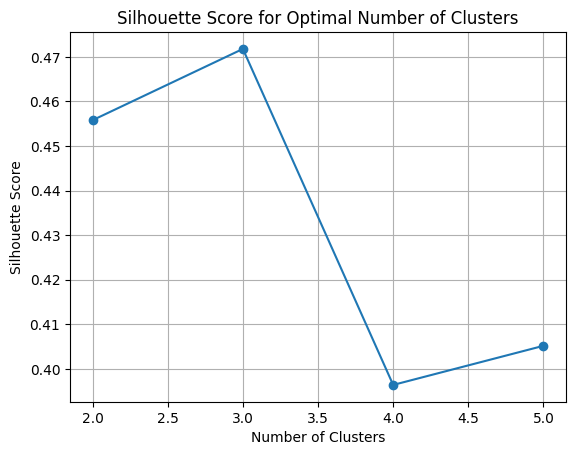

In [25]:
from sklearn.cluster import Birch
scaled_df = StandardScaler().fit_transform(df_known_no_label)

# Используем метод локтя для определения оптимального числа кластеров
sse = []
silhouette_scores = []
for k in range(2, 6):
    birch_clustering = Birch(n_clusters=k)
    y_pred = birch_clustering.fit_predict(scaled_df)
    silhouette_scores.append(silhouette_score(scaled_df, y_pred))

plt.plot(range(2, 6), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.grid(True)
plt.show()

In [28]:
scale = StandardScaler().fit(df_known_no_label)
scaled_df = scale.transform(df_known_no_label)
# scaled_df = df_known_no_label
birch_clustering = Birch(n_clusters=2)
y_pred = birch_clustering.fit_predict(scaled_df)
count_cluster_0 = np.sum(y_pred == 0)
count_cluster_1 = np.sum(y_pred == 1)
df_known['predict'] = y_pred

print("На известных данных")
count_first = df_known[(df_known['mutation'] == 1) & (df_known['predict'] == 0)].shape[0]
count_second = df_known[(df_known['mutation'] == 1) & (df_known['predict'] == 1)].shape[0]
print(f"Количество точек в первом / втором кластере: {count_cluster_0} (мутаций из них {count_first}) / {count_cluster_1} (мутаций из них {count_second})")
print(f"Количество в оригинальном датасете: {(df['mutation'] == 1).sum()} / {(df['mutation'] == 0).sum()}")

print("\nНа неизвестных данных")
scaled_df = scale.transform(df_unknown_no_label)
y_pred = birch_clustering.predict(scaled_df)
count_cluster_0 = np.sum(y_pred == 0)
count_cluster_1 = np.sum(y_pred == 1)
print(f"Количество точек в первом / втором кластере: {count_cluster_0} / {count_cluster_1}")

На известных данных
Количество точек в первом / втором кластере: 81 (мутаций из них 60) / 18 (мутаций из них 14)
Количество в оригинальном датасете: 74 / 25

На неизвестных данных
Количество точек в первом / втором кластере: 47 / 14


<ipython-input-28-cf7f72c52bec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_known['predict'] = y_pred


# HDBSCAN

In [29]:
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 24.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039297 sha256=9b43adcc47a827d72588a02cdc12705560e299640185d41049eeb4fa03fb0f32
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.10
    Uninstalling Cython-3.0.10:
      Successfully uninstalled Cython-3.0.10


In [30]:
df_known_no_label = df_known.drop(df.columns[-2:], axis=1)
df_unknown_no_label = df_unknown.drop(df.columns[-2:], axis=1)
df_known = df.loc[df['mutation'].isin([1, 0])]

In [31]:
import hdbscan
#scaled_df = StandardScaler().fit_transform(df_known_no_label)
scaled_df = df_known_no_label
# Используем метод локтя для определения оптимального числа кластеров

dbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=5)
y_pred = dbscan_cluster.fit_predict(scaled_df)
print(y_pred)

[ 1  2 -1 -1  1 -1 -1  1 -1  1 -1 -1 -1 -1  2 -1 -1 -1  1  0 -1 -1  1  0
  1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1  2 -1  1  1 -1 -1  1
 -1 -1 -1 -1 -1 -1  1  2  0 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  2  1 -1  1 -1
 -1 -1  1 -1 -1  1  1 -1  2  1  1  1 -1 -1 -1  1 -1 -1  2  1 -1  0 -1  1
 -1  1 -1]


In [32]:
from sklearn.cluster import DBSCAN
scaled_df = StandardScaler().fit_transform(df_known_no_label)
#scaled_df = df_known_no_label
db = DBSCAN(eps=10, min_samples=10, metric='euclidean', metric_params=None, algorithm='brute', leaf_size=30, p=None, n_jobs=None).fit(scaled_df)
labels = db.labels_
print(labels)

[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0
  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0 -1  0  0  0  0
  0  0 -1]


In [33]:
df_known['predict'] = labels

print("На известных данных")
count_cluster_0 = np.sum(labels == 0)
count_cluster_1 = np.sum(labels == -1)
count_first = df_known[(df_known['mutation'] == 1) & (df_known['predict'] == 0)].shape[0]
count_second = df_known[(df_known['mutation'] == 1) & (df_known['predict'] == -1)].shape[0]
print(f"Количество точек в первом / втором кластере: {count_cluster_0} (мутаций из них {count_first}) / {count_cluster_1} (мутаций из них {count_second})")

На известных данных
Количество точек в первом / втором кластере: 91 (мутаций из них 69) / 8 (мутаций из них 5)


<ipython-input-33-c252f789b7c3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_known['predict'] = labels


# OPTICS

In [34]:
df_known_no_label = df_known.drop(df.columns[-2:], axis=1)
df_unknown_no_label = df_unknown.drop(df.columns[-2:], axis=1)

In [35]:
from sklearn.cluster import OPTICS
df_all_no_label = df.drop(df.columns[-2:], axis=1)

#scaled_df = StandardScaler().fit_transform(df_all_no_label)
scaled_df = df_all_no_label
optics_clustering = OPTICS(min_samples=5, max_eps=np.inf)

# Предсказываем кластеры
y_pred = optics_clustering.fit_predict(scaled_df)
print(y_pred)

[-1 -1  4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1  1 -1 -1 -1  1  3
  1 -1 -1 -1 -1  3 -1 -1 -1 -1  5 -1  1  4 -1 -1  1  2 -1 -1 -1 -1  4 -1
 -1 -1  4  4 -1 -1 -1  2  3  5 -1  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  3
 -1 -1  0 -1 -1  0  1 -1  2  0 -1  0  4 -1 -1 -1 -1 -1 -1 -1 -1  3 -1 -1
 -1 -1 -1  4 -1  0  1  0 -1 -1 -1  0 -1  1  3  4 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  5 -1 -1  2 -1  3 -1 -1 -1  1 -1 -1 -1 -1]
